In [72]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from lightgbm import early_stopping
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import optuna
import xgboost as xgb

# Чтение файлов

In [80]:
df_users = pd.read_csv("users.tsv", sep="\t")
history = pd.read_csv("history.tsv", sep="\t")
validate_answers = pd.read_csv("validate_answers.tsv", sep="\t")
validate =pd.read_csv("validate.tsv", sep="\t")

## 1. Подготовим датасет по историческим данным. Уберем выбросы в стоимости рекламы

In [3]:
# Вычисляем границы выбросов
Q1 = history['cpm'].quantile(0.25)
Q3 = history['cpm'].quantile(0.75)
IQR = Q3 - Q1

In [4]:
df_history = history[(history['cpm'] >= Q1 - 1.5 * IQR) & (history['cpm'] <= Q3 + 1.5 * IQR)]

In [5]:
df_history

,hour,cpm,publisher,user_id
0,10,30.00,1,15661
1,8,41.26,1,8444
2,7,360.00,1,15821
3,18,370.00,1,21530
4,8,195.00,2,22148
...,...,...,...,...
1147852,382,45.00,1,7871
1147853,360,33.35,1,7992
1147854,381,205.00,1,21516
1147855,383,37.50,1,8224


## 2. Теперь надо обогатить данные из history.tsv 

#### Делаем статистику по пользователям, площадкам и времени

In [ ]:
df_history

In [6]:
# Фичи по пользователям
user_stats = df_history.groupby('user_id').agg(
    user_total_ads=('hour', 'count'),  # Общее число показов
    user_mean_cpm=('cpm', 'mean'),  # Средний CPM
    user_max_cpm=('cpm', 'max'),  # Максимальный CPM
    user_unique_publishers=('publisher', 'nunique'),  # Кол-во уникальных площадок
).reset_index()

In [7]:
# Фичи по площадкам
publisher_stats = df_history.groupby('publisher').agg(
    publisher_mean_cpm=('cpm', 'mean'),
    publisher_total_сads=('hour', 'count')
).reset_index()

In [8]:
# Фичи по времени (часу)
hour_stats = df_history.groupby('hour').agg(
    hour_total_ads=('user_id', 'count'),
    hour_mean_cpm=('cpm', 'mean')
).reset_index()

In [9]:
hour_stats

,hour,hour_total_ads,hour_mean_cpm
0,3,177,149.997627
1,4,239,134.114770
2,5,354,133.723192
3,6,462,134.877576
4,7,686,125.843382
...,...,...,...
1483,1486,888,121.200034
1484,1487,692,107.440925
1485,1488,513,168.278616
1486,1489,344,174.017384


## 3. Фичи из users.tsv 

In [10]:
# Бинарные фичи по полу
df_users['is_male'] = df_users['sex'].map({1: 0, 2: 1, 0: -1})  # -1 = неизвестно

In [11]:
df_users['age_group'] = pd.cut(
    df_users['age'], bins=[0, 18, 25, 35, 45, 60, 100], labels=[1, 2, 3, 4, 5, 6]
).astype('float')  # Делаем float, чтобы можно было добавить -1

df_users.loc[df_users['age'] == 0, 'age_group'] = -1  # -1 = неизвестный возраст

In [12]:
# Убираем ненужные колонки
df_users = df_users[['user_id', 'is_male', 'age_group', 'city_id']]

In [13]:
df_users

,user_id,is_male,age_group,city_id
0,0,1,2.0,0
1,1,0,-1.0,1
2,2,1,2.0,2
3,3,0,2.0,3
4,4,1,3.0,4
...,...,...,...,...
27764,27764,0,4.0,295
27765,27765,1,3.0,79
27766,27766,1,2.0,1953
27767,27767,1,1.0,0


## 4. Обогощаем validate.tsv 

In [14]:
df_validate = pd.read_csv("validate.tsv", sep="\t")

df_validate['user_ids'] = df_validate['user_ids'].str.split(',')  # Разделяем строку на список
df_validate_expanded = df_validate.explode('user_ids')  # Разворачиваем список
df_validate_expanded = df_validate_expanded.rename(columns={'user_ids': 'user_id'})  # Переименовываем


df_validate_expanded['user_id'] = df_validate_expanded['user_id'].astype(int)

# Присоединяем фичи пользователей
df_validate_expanded = df_validate_expanded.merge(df_users, on='user_id', how='left')
df_validate_expanded = df_validate_expanded.merge(user_stats, on='user_id', how='left')


# Присоединяем среднюю статистику по площадкам (усредняем по списку `publishers`)
df_validate_expanded['publishers'] = df_validate_expanded['publishers'].str.split(',')
df_validate_expanded = df_validate_expanded.explode('publishers')
df_validate_expanded['publishers'] = df_validate_expanded['publishers'].astype(int)

df_validate_expanded = df_validate_expanded.merge(publisher_stats, left_on='publishers', right_on='publisher', how='left')

# Группируем обратно по объявлениям (усредняем по пользователям и площадкам)
df_validate_final = df_validate_expanded.groupby(['cpm', 'hour_start', 'hour_end']).agg(
    avg_user_total_ads=('user_total_ads', 'mean'),
    avg_user_mean_cpm=('user_mean_cpm', 'mean'),
    avg_user_max_cpm=('user_max_cpm', 'mean'),
    avg_user_unique_publishers=('user_unique_publishers', 'mean'),
    avg_publisher_mean_cpm=('publisher_mean_cpm', 'mean'),
    avg_publisher_total_ads=('publisher_total_ads', 'mean'),
    avg_is_male=('is_male', 'mean'),
    avg_age_group=('age_group', 'mean'),
    avg_city_id=('city_id', 'mean')
).reset_index()



In [15]:
# Добавляем взаимодействие между ценой и временем начала
df_validate_final['cpm_hour_start_interaction'] = df_validate_final['cpm'] * df_validate_final['hour_start']

# Добавляем взаимодействие между ценой и временем окончания
df_validate_final['cpm_hour_end_interaction'] = df_validate_final['cpm'] * df_validate_final['hour_end']

# Добавляем разницу между временем начала и конца
df_validate_final['hour_duration'] = df_validate_final['hour_end'] - df_validate_final['hour_start']

# Добавляем отношение времени конца к времени начала
df_validate_final['hour_end_to_start_ratio'] = df_validate_final['hour_end'] / (df_validate_final['hour_start'] + 1e-5)  # добавляем маленькую константу, чтобы избежать деления на 0


In [16]:
# Преобразование времени в более осмысленные фичи
df_validate_final['hour_start_dayofweek'] = df_validate_final['hour_start'] // 24  # Пример: день недели
df_validate_final['hour_start_hour'] = df_validate_final['hour_start'] % 24  # Пример: час дня


In [17]:
df_validate_final['normalized_hour_start'] = df_validate_final['hour_start'] / 1485
df_validate_final['normalized_hour_end'] = df_validate_final['hour_end'] / 1488


df_validate_final['sin_hour_start'] = np.sin(2 * np.pi * df_validate_final['normalized_hour_start'])
df_validate_final['cos_hour_start'] = np.cos(2 * np.pi * df_validate_final['normalized_hour_start'])


df_validate_final['sin_hour_end'] = np.sin(2 * np.pi * df_validate_final['normalized_hour_end'])
df_validate_final['cos_hour_end'] = np.cos(2 * np.pi * df_validate_final['normalized_hour_end'])

In [18]:
df_validate_final

,cpm,hour_start,hour_end,avg_user_total_ads,avg_user_mean_cpm,avg_user_max_cpm,avg_user_unique_publishers,avg_publisher_mean_cpm,avg_publisher_total_ads,avg_is_male,...,hour_duration,hour_end_to_start_ratio,hour_start_dayofweek,hour_start_hour,normalized_hour_start,normalized_hour_end,sin_hour_start,cos_hour_start,sin_hour_end,cos_hour_end
0,30.0,767,1009,1.886640,149.732794,183.095870,1.117409,134.467883,32026.000000,0.494845,...,242,1.315515,31,23,0.516498,0.678091,-0.103476,-0.994632,-0.899656,-0.436599
1,30.0,772,778,43.198925,153.058151,312.216667,1.469086,103.734158,79371.000000,0.467857,...,6,1.007772,32,4,0.519865,0.522849,-0.124494,-0.992220,-0.143075,-0.989712
2,30.0,785,795,40.965167,154.845325,311.319753,1.419448,134.602464,316107.333333,0.485825,...,10,1.012739,32,17,0.528620,0.534274,-0.178854,-0.983876,-0.213690,-0.976901
3,30.0,789,862,1.222849,156.572306,165.795966,1.026798,114.028776,62573.666667,0.502899,...,73,1.092522,32,21,0.531313,0.579301,-0.195479,-0.980708,-0.477901,-0.878414
4,30.0,802,856,45.198077,195.647203,349.014115,1.369231,113.016997,43081.000000,0.493421,...,54,1.067332,33,10,0.540067,0.575269,-0.249100,-0.968478,-0.455495,-0.890238
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1003,467.0,1200,1276,43.485320,160.812897,325.872712,1.436960,138.658186,57363.000000,0.541667,...,76,1.063333,50,0,0.808081,0.857527,-0.934148,0.356886,-0.780325,0.625374
1004,467.0,1281,1291,7.629213,272.005946,356.453446,1.333333,133.331143,123757.000000,0.434211,...,10,1.007806,53,9,0.862626,0.867608,-0.759890,0.650051,-0.739176,0.673512
1005,472.0,761,968,41.464677,139.628167,299.202299,1.499005,110.828759,178639.250000,0.484821,...,207,1.272010,31,17,0.512458,0.650538,-0.078195,-0.996938,-0.810998,-0.585049
1006,474.0,1001,1005,7.758032,272.278558,355.499629,1.336345,110.435646,62897.333333,0.412048,...,4,1.003996,41,17,0.674074,0.675403,-0.888350,-0.459166,-0.892154,-0.451732


In [29]:
scaler = StandardScaler()

scaler.fit(df_validate_final)
df_scaler = scaler.transform(df_validate_final)

In [30]:
df_scaler

array([[-1.18092351, -1.5451714 , -0.81856937, ..., -1.28115042,
        -0.73067711, -0.92758606],
       [-1.18092351, -1.51924976, -2.02123617, ..., -1.27743213,
         1.86746222, -1.78410293],
       [-1.18092351, -1.4518535 , -1.93272822, ..., -1.26456523,
         1.62496422, -1.76426542],
       ...,
       [ 2.76067244, -1.57627737, -1.03202971, ..., -1.28470626,
        -0.42622037, -1.15746645],
       [ 2.77850772, -0.33203871, -0.83939477, ..., -0.45551585,
        -0.70491397, -0.95101925],
       [ 2.78742536,  0.64779924,  0.24873233, ...,  0.74133884,
        -0.78541096,  0.37117655]])

In [31]:
print(df_validate_final.info())  # Проверим типы данных и пропущенные значения
print(df_validate_final.head())  # Посмотрим, как выглядят данные


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1008 entries, 0 to 1007
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   cpm                         1008 non-null   float64
 1   hour_start                  1008 non-null   int64  
 2   hour_end                    1008 non-null   int64  
 3   avg_user_total_ads          1008 non-null   float64
 4   avg_user_mean_cpm           1008 non-null   float64
 5   avg_user_max_cpm            1008 non-null   float64
 6   avg_user_unique_publishers  1008 non-null   float64
 7   avg_publisher_mean_cpm      1008 non-null   float64
 8   avg_publisher_total_ads     1008 non-null   float64
 9   avg_is_male                 1008 non-null   float64
 10  avg_age_group               1008 non-null   float64
 11  avg_city_id                 1008 non-null   float64
 12  cpm_hour_start_interaction  1008 non-null   float64
 13  cpm_hour_end_interaction    1008 

## 5. Запускаем модель

In [61]:
# Целевая переменная (доля пользователей, которые увидят рекламу хотя бы один раз)
target_columns = ['at_least_one', 'at_least_two', 'at_least_three']
X = final_dataset.drop('seen_ids', axis=1)
y = final_dataset['seen_ids']  # Целевая переменная

# Разделяем данные на обучающую и тестовую выборки (например, 80% - обучение, 20% - тест)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [62]:
# Параметры модели
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'max_depth': 7
}

# Создаем callback для ранней остановки
callbacks = [early_stopping(stopping_rounds=10)]

In [63]:
y_train_1 = y_train['at_least_one']
y_train_2 = y_train['at_least_two']
y_train_3 = y_train['at_least_three']

KeyError: 'at_least_one'

In [64]:
# Создаем Dataset для тренировочных и валидационных данных с free_raw_data=False
train_data_1 = lgb.Dataset(X_train, label=y_train_1, free_raw_data=False)
train_data_2 = lgb.Dataset(X_train, label=y_train_2, free_raw_data=False)
train_data_3 = lgb.Dataset(X_train, label=y_train_3, free_raw_data=False)

# Для тестового набора передаем соответствующий столбец меток
test_data_1 = lgb.Dataset(X_test, label=y_test['at_least_one'], free_raw_data=False)
test_data_2 = lgb.Dataset(X_test, label=y_test['at_least_two'], free_raw_data=False)
test_data_3 = lgb.Dataset(X_test, label=y_test['at_least_three'], free_raw_data=False)

KeyError: 'at_least_one'

In [48]:
model_1 = lgb.train(params, train_data_1, valid_sets=[test_data_1], num_boost_round=1000, callbacks=callbacks)
model_2 = lgb.train(params, train_data_2, valid_sets=[test_data_2], num_boost_round=1000, callbacks=callbacks)
model_3 = lgb.train(params, train_data_3, valid_sets=[test_data_3], num_boost_round=1000, callbacks=callbacks)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039517 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5465
[LightGBM] [Info] Number of data points in the train set: 806, number of used features: 24
[LightGBM] [Info] Start training from score 0.117073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

In [38]:
model_1 = LinearRegression()
model_1.fit(X_train, y_train_1)

model_2 = LinearRegression()
model_2.fit(X_train, y_train_2)

model_3 = LinearRegression()
model_3.fit(X_train, y_train_3)

LinearRegression()

In [49]:
# Прогнозы на тестовых данных
y_pred_1 = model_1.predict(X_test)
y_pred_2 = model_2.predict(X_test)
y_pred_3 = model_3.predict(X_test)
# Применим метрику
from sklearn.metrics import mean_absolute_error

mae_1 = mean_absolute_error(y_test['at_least_one'], y_pred_1)
mae_2 = mean_absolute_error(y_test['at_least_two'], y_pred_2)
mae_3 = mean_absolute_error(y_test['at_least_three'], y_pred_3)

r2_1 = r2_score(y_test['at_least_one'], y_pred_1)
r2_2 = r2_score(y_test['at_least_two'], y_pred_2)
r2_3 = r2_score(y_test['at_least_three'], y_pred_3)
print(f'Mean Absolute Error for one: {mae_1}')
print(f'Mean Absolute Error for two: {mae_2}')
print(f'Mean Absolute Error for three: {mae_3}')


print(f'R^2 for one: {r2_1}')
print(f'R^2 for two: {r2_2}')
print(f'R^2 ffor three: {r2_3}')

Mean Absolute Error for one: 0.10787033403999216
Mean Absolute Error for two: 0.07808952027872483
Mean Absolute Error for three: 0.06048913639600619
R^2 for one: -0.00821003285502786
R^2 for two: -0.003924451912022953
R^2 ffor three: 0.0021757285375109126


In [50]:
answers_df = pd.DataFrame({
    'at_least_one' : y_test['at_least_one'],
    'at_least_two' : y_test['at_least_two'],
    'at_least_three' : y_test['at_least_three']
})

In [51]:
predictions_df = pd.DataFrame({
    'at_least_one' : y_pred_1,
    'at_least_two' : y_pred_2,
    'at_least_three' : y_pred_3 
})

In [52]:
predictions_df.to_csv('predictions.csv', index=False)
answers_df.to_csv('answers.csv', index=False)

In [53]:
! python metrics_my.py answers.csv predictions.csv

Answers DataFrame:
    at_least_one  at_least_two  at_least_three
0        0.0138        0.0000          0.0000
1        0.0272        0.0000          0.0000
2        0.0279        0.0086          0.0027
3        0.0305        0.0213          0.0137
4        0.0507        0.0160          0.0040
Responses DataFrame:
    at_least_one  at_least_two  at_least_three
0      0.116039      0.064523        0.042425
1      0.115717      0.065355        0.042422
2      0.116039      0.064523        0.043386
3      0.122941      0.064382        0.042254
4      0.116491      0.067396        0.046159
366.79


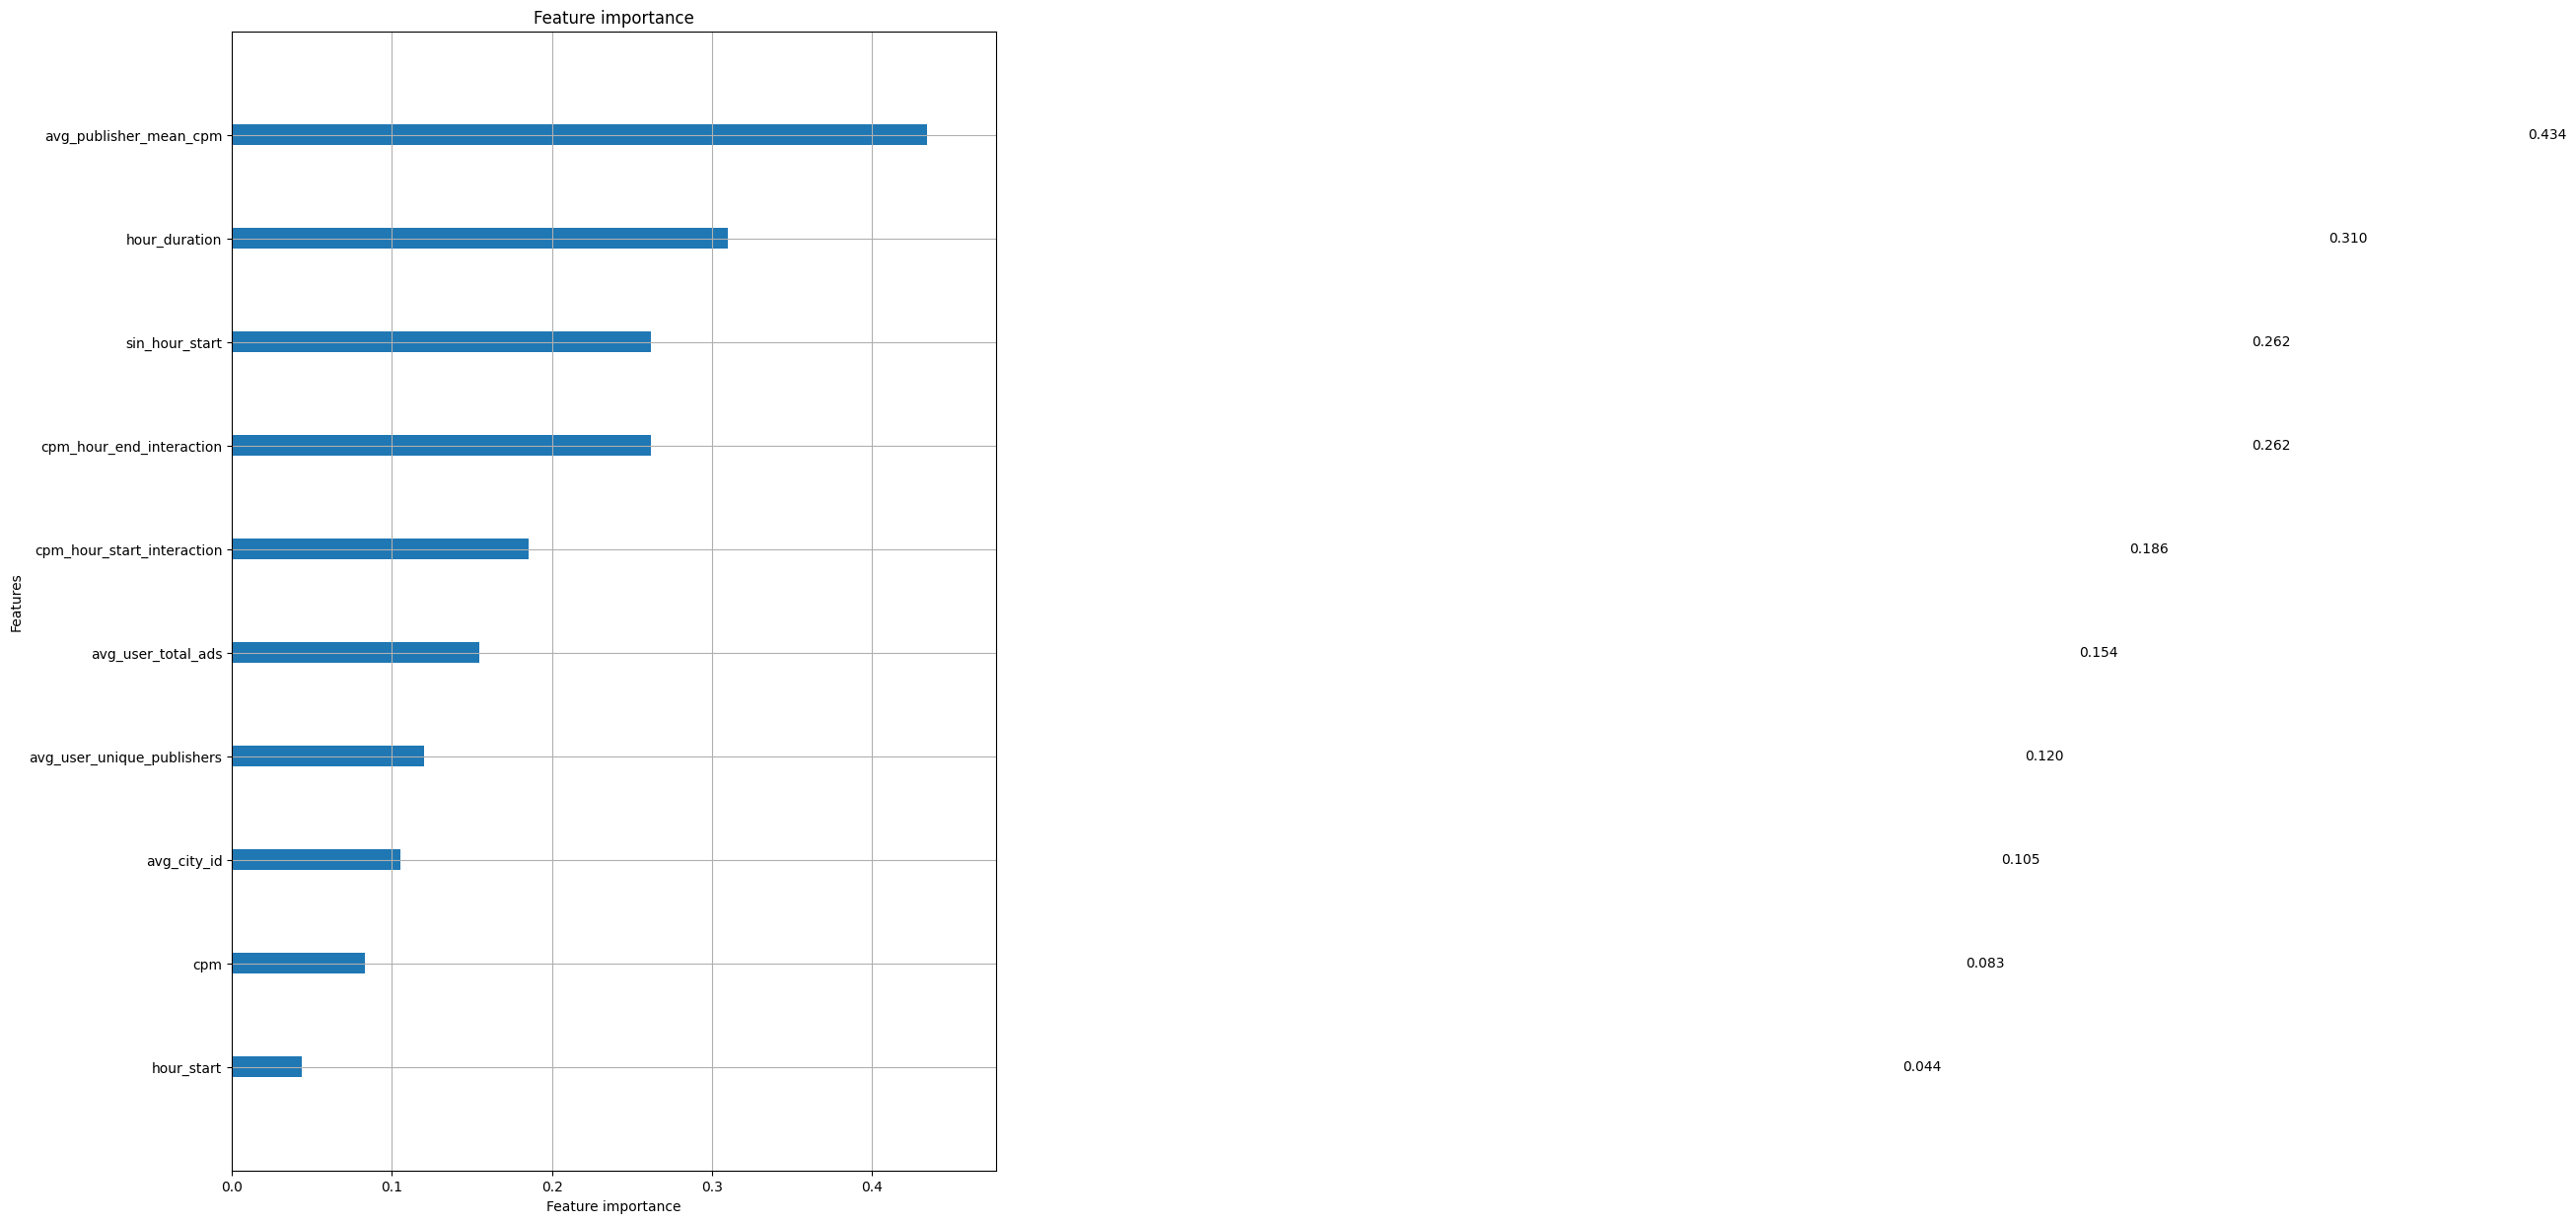

In [54]:
lgb.plot_importance(model_1, importance_type='gain', figsize=(10, 15))
plt.show()


In [1]:
import pandas as pd

history = pd.read_csv('history.tsv', sep='\t')
users = pd.read_csv('users.tsv', sep='\t')
validate = pd.read_csv('validate.tsv', sep='\t')

# Преобразуйте данные в формат JSON
history_json = history.to_json(orient='split')
users_json = users.to_json(orient='split')
validate_json = validate.to_json(orient='split')


In [3]:
import pandas as pd
import requests

history = pd.read_csv("history.tsv", sep="\t").to_dict(orient="records")
users = pd.read_csv("users.tsv", sep="\t").to_dict(orient="records")
validate = pd.read_csv("validate.tsv", sep="\t").to_dict(orient="records")

data = {"history": history, "users": users, "validate": validate}

response = requests.post("http://localhost:5000/predict", json=data)
print(response.json())


JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [5]:
! curl http://localhost:5000


<!doctype html>
<html lang=en>
<title>404 Not Found</title>
<h1>Not Found</h1>
<p>The requested URL was not found on the server. If you entered the URL manually please check your spelling and try again.</p>


In [2]:
! curl -X POST -H "Content-Type: application/json" -d '{"history": <history_json>, "users": <users_json>, "validate": <validate_json>}' http://localhost:5000/predict


<!doctype html>
<html lang=en>
  <head>
    <title>werkzeug.exceptions.BadRequestKeyError: 400 Bad Request: The browser (or proxy) sent a request that this server could not understand.
KeyError: &#39;history&#39;
 // Werkzeug Debugger</title>
    <link rel="stylesheet" href="?__debugger__=yes&amp;cmd=resource&amp;f=style.css">
    <link rel="shortcut icon"
        href="?__debugger__=yes&amp;cmd=resource&amp;f=console.png">
    <script src="?__debugger__=yes&amp;cmd=resource&amp;f=debugger.js"></script>
    <script>
      var CONSOLE_MODE = false,
          EVALEX = true,
          EVALEX_TRUSTED = false,
          SECRET = "nz7evVFa7wZLpwIv6Hto";
    </script>
  </head>
  <body style="background-color: #fff">
    <div class="debugger">
<h1>BadRequestKeyError</h1>
<div class="detail">
  <p class="errormsg">werkzeug.exceptions.BadRequestKeyError: 400 Bad Request: The browser (or proxy) sent a request that this server could not understand.
KeyError: &#39;history&#39;
</p>
</div>
<h2 clas